In [6]:
import math
import strawberryfields as sf
# from cvxopt import solvers, matrix, spmatrix, mul
from scipy import sparse


def takagi_real(H, cut=50):
    sing_vs_max, Q_max = LA.eigh(H, subset_by_index=[0, cut], overwrite_a=True)
    sing_vs_min, Q_min = LA.eigh(
        H, subset_by_index=[n-cut, n-1], overwrite_a=True)
    sing_vs = np.append(sing_vs_max, sing_vs_min)
    Q = np.append(Q_max, Q_min, axis=1)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    return vs, Qp


def fit_J(w, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] - 1.j * w)
    return res


def fit_t(t, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] * np.exp(-expn[i] * t)
    return res


def numpy_to_cvxopt_matrix(A):
    if A is None:
        return A
    if sparse.issparse(A):
        if isinstance(A, sparse.spmatrix):
            return scipy_sparse_to_spmatrix(A)
        else:
            return A
    else:
        if isinstance(A, np.ndarray):
            if A.ndim == 1:
                return matrix(A, (A.shape[0], 1), 'd')
            else:
                return matrix(A, A.shape, 'd')
        else:
            return A


In [7]:
alpha = 1
s = 0.5
beta = 1


def gen_jw(w):
    return np.pi / 2 * alpha * (w > 0) * (w + 0.j)**(s) * np.exp(-np.abs(w))


(-10.0, 10.0)

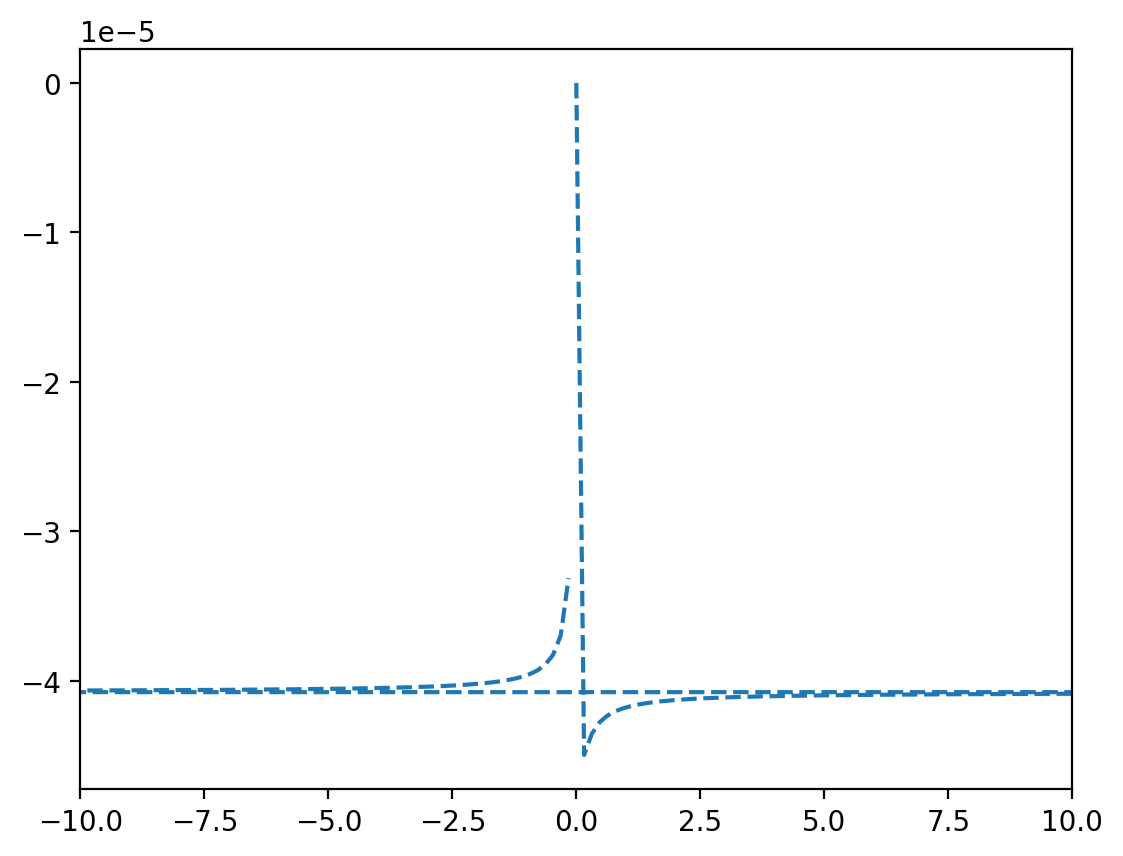

In [8]:
n = 1000
n_fft = (4 * n + 1)
scale_fft = 100

w1 = np.linspace(0, scale_fft * np.pi, n_fft + 1)[:-1]
dw = w1[1] - w1[0]
cw1 = gen_jw(w1)

fft_ct = (np.fft.fft(cw1) * dw / (np.pi))[:(2*n+1)]
fft_t = 2 * np.pi * np.fft.fftfreq(len(cw1), dw)[:(2*n+1)]

# fft_ct = fft_ct - fft_ct[-1]
fft_ct[0] = fft_ct[0] / 2
w1 = 2 * np.pi * np.fft.fftfreq(len(fft_ct), fft_t[1] - fft_t[0])
jw1 = gen_jw(w1)
plt.plot(w1,
         jw1 - len(fft_ct) * (fft_t[1] - fft_t[0]) * np.fft.ifft(fft_ct), '--')
fft_ct[0] = fft_ct[0] * 2
plt.xlim(-10, 10)


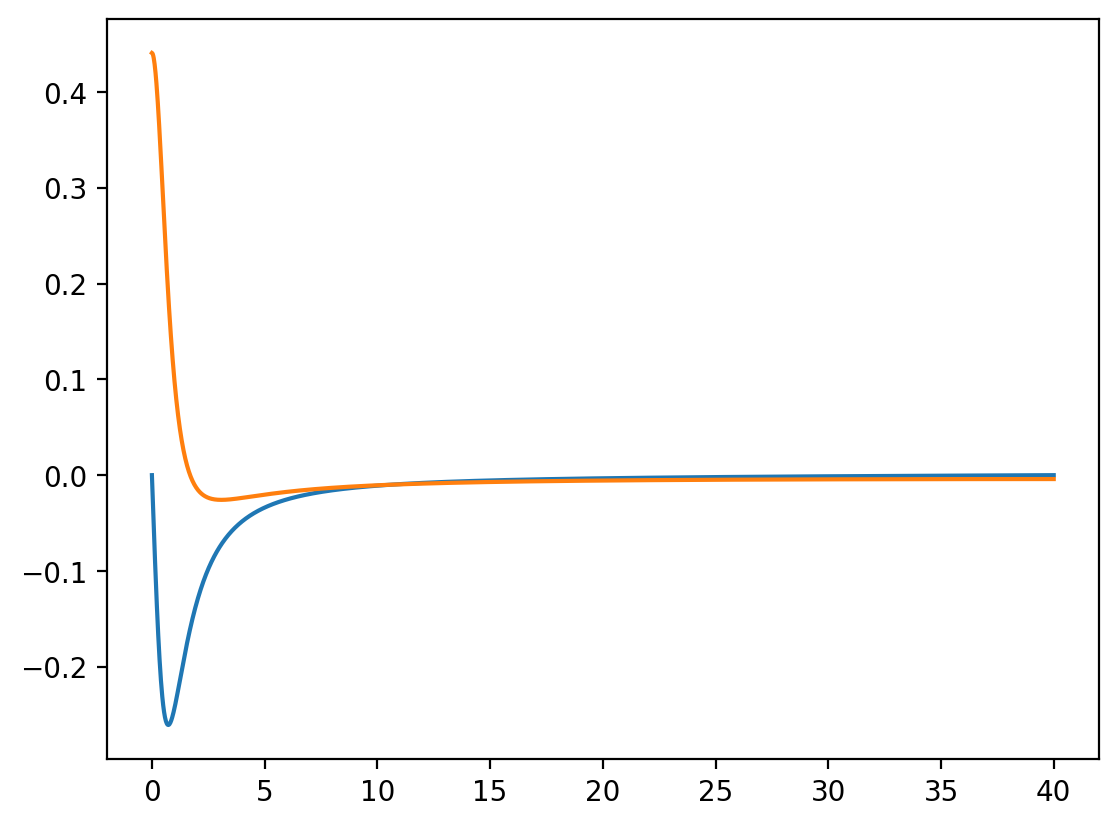

[0.44084875+5.89658567e-18j 0.44051659-1.32852016e-02j
 0.4395222 -2.65239913e-02j 0.43787181-3.96704146e-02j
 0.43557572-5.26794236e-02j 0.43264814-6.55073082e-02j
 0.42910699-7.81121018e-02j 0.42497367-9.04539544e-02j
 0.42027277-1.02495468e-01j 0.41503171-1.14201983e-01j]


In [9]:
plt.plot(fft_t, np.imag(fft_ct))
plt.plot(fft_t, np.real(fft_ct))
# plt.xlim(0, 200)
plt.show()
print(fft_ct[:10])


In [ ]:
n_sample = n
H_r = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H_r[i, :] = np.real(h[i:n_sample + i])
vs_r, Qp_r = takagi_real(H_r, 20)
del H_r
gc.collect()
sort_array = np.argsort(vs_r)[::-1]
vs_r = vs_r[sort_array]
Qp_r = (Qp_r[:, sort_array])
np.save('Qp_r.npy', Qp_r)
np.save('vs_r.npy', vs_r)
print(vs_r[:40])

H_i = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H_i[i, :] = np.imag(h[i:n_sample + i])
vs_i, Qp_i = takagi_real(H_i, 20)
del H_i
gc.collect()
sort_array = np.argsort(vs_i)[::-1]
vs_i = vs_i[sort_array]
Qp_i = (Qp_i[:, sort_array])
np.save('Qp_i.npy', Qp_i)
np.save('vs_i.npy', vs_i)
print(vs_i[:40])


In [5]:
len_ = 100000
spe_wid = 20
w = np.append(np.linspace(-spe_wid, 0, len_),
              np.linspace(0, spe_wid, len_))
phixx = gen_jw(w)
scale = fft_t[-1]
for (n_gamma_r, n_gamma_i) in [(8, 7)]:
    # gamma_r = np.polynomial.polynomial.polyroots(Qp_r[:, n_gamma_r])
    gamma_r = np.load("gamma_new_r.npy")
    gamma_new_r = gamma_r[np.argsort(np.abs(gamma_r))[:n_gamma_r]]
    t_new_r = 2*n*np.log((gamma_new_r))

    # gamma_i = np.polynomial.polynomial.polyroots(Qp_i[:, n_gamma_i])
    gamma_i = np.load("gamma_new_i.npy")
    gamma_new_i = gamma_i[np.argsort(np.abs(gamma_i))[:n_gamma_i]]
    t_new_i = 2*n*np.log(gamma_new_i)

    # gamma_new = np.append(gamma_new_r, gamma_new_i)

    # n_gamma = n_gamma_r + n_gamma_i
    n_col = len(h)
    n_row = n_gamma_r
    gamma_m = np.zeros((2 * n_col, 2 * n_row), dtype=float)
    for i in range(n_row):
        for j in range(n_col):
            gamma_m[j, i] = np.real(gamma_new_r[i]**j)
            gamma_m[n_col + j, n_row + i] = np.real(gamma_new_r[i]**j)
            gamma_m[j, n_row + i] = -np.imag(gamma_new_r[i]**j)
            gamma_m[n_col + j, i] = np.imag(gamma_new_r[i]**j)
    h_m = np.append(np.real(h), np.zeros_like(h))
    omega_new_temp_r = (LA.inv(np.transpose(gamma_m) @ gamma_m)
                        @ np.transpose(gamma_m) @ np.transpose(h_m)).reshape(
        2, n_gamma_r)
    omega_new_r = omega_new_temp_r[0, :] + 1.j*omega_new_temp_r[1, :]

    n_col = len(h)
    n_row = n_gamma_i
    gamma_m = np.zeros((2 * n_col, 2 * n_row), dtype=float)
    for i in range(n_row):
        for j in range(n_col):
            gamma_m[j, i] = np.real(gamma_new_i[i]**j)
            gamma_m[n_col + j, n_row + i] = np.real(gamma_new_i[i]**j)
            gamma_m[j, n_row + i] = -np.imag(gamma_new_i[i]**j)
            gamma_m[n_col + j, i] = np.imag(gamma_new_i[i]**j)
    h_m = np.append(np.zeros_like(h), np.imag(h))
    omega_new_temp_i = (LA.inv(np.transpose(gamma_m) @ gamma_m)
                        @ np.transpose(gamma_m) @ np.transpose(h_m)).reshape(
        2, n_gamma_i)
    omega_new_i = omega_new_temp_i[0, :] + 1.j*omega_new_temp_i[1, :]

    etal = np.append(omega_new_r, omega_new_i).copy()

    t_new = np.append(t_new_r, t_new_i)
    expn = -t_new / scale
print(expn)


FileNotFoundError: [Errno 2] No such file or directory: 'gamma_new_r.npy'

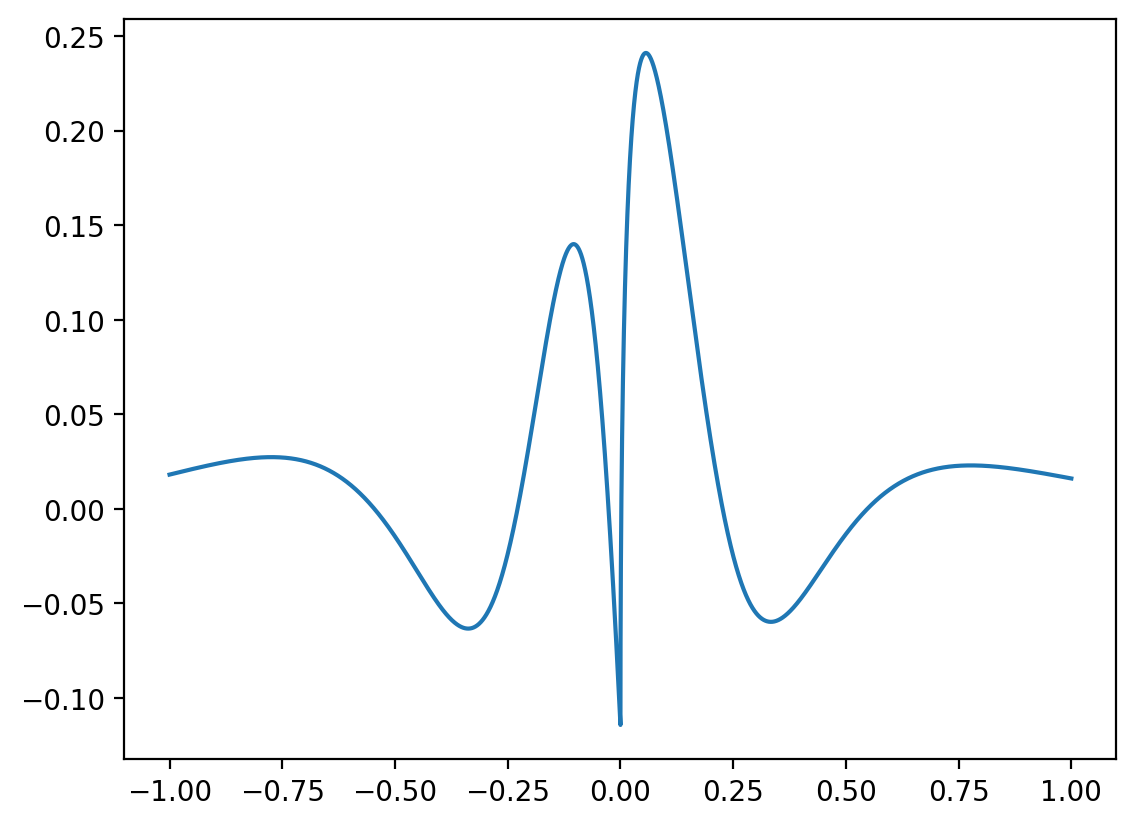

In [7]:
len_ = 1000000
spe_wid = 1
alpha = 0.4
w = np.append(np.linspace(-spe_wid, 0, len_), np.linspace(0, spe_wid, len_))


def gen_wc_jw(w, wc):
    return np.pi / 2 * alpha * (w > 0) * (wc)**(1 - s) * (w + 0.j)**(s) * np.exp(-np.abs(w / wc))


phixx = gen_wc_jw(w, 20)
res_J = np.zeros(len(w), dtype=complex)
fit_J(w, res_J, expn * 20, alpha * etal * 20 * 20)
np.savetxt('expn-{}'.format(len(expn)), expn * 20)
np.savetxt('etal-{}'.format(len(etal)), alpha * etal * 20 * 20)
plt.plot(w, phixx-res_J.real)


(0.0, 1.0)

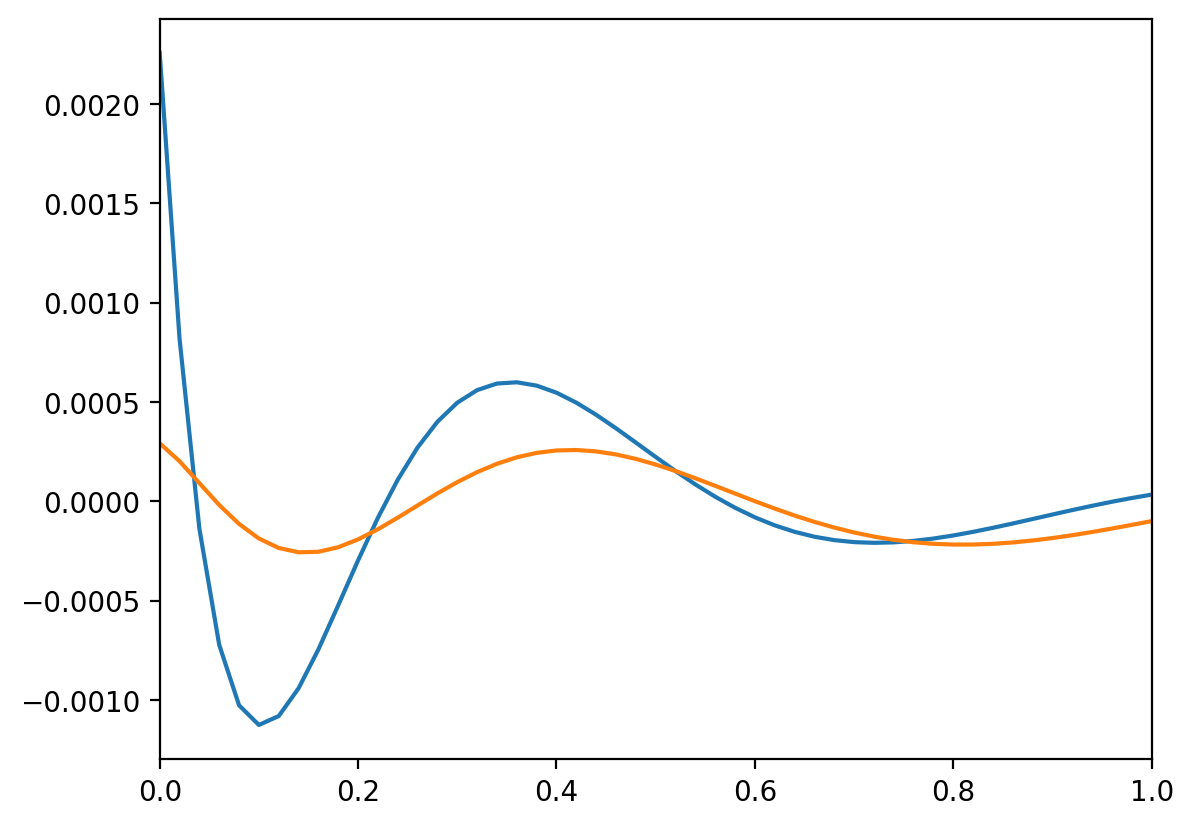

In [36]:
prony_ft = np.zeros_like(fft_t, dtype=complex)
fit_t(fft_t, prony_ft, expn, etal)
plt.plot(fft_t, (np.imag(fft_ct) - np.imag(prony_ft)))
# plt.plot(fft_t, (np.imag(fft_ct)- np.imag(prony_ft)))
plt.plot(fft_t, (np.real(fft_ct) - np.real(prony_ft)))
# plt.plot(fft_t, (np.real(fft_ct) - np.real(prony_ft)))
# plt.ylim(-1e-5, 1e-5)
plt.xlim(0, 1)

# plt.plot(fft_t, np.real(fft_ct))


[0.42530719 0.5099729  0.63020029 0.78519639]
[ 2.59768856e-04  1.61215490e+00 -3.39050627e-05  9.92783969e-01]


(0.0, 10.0)

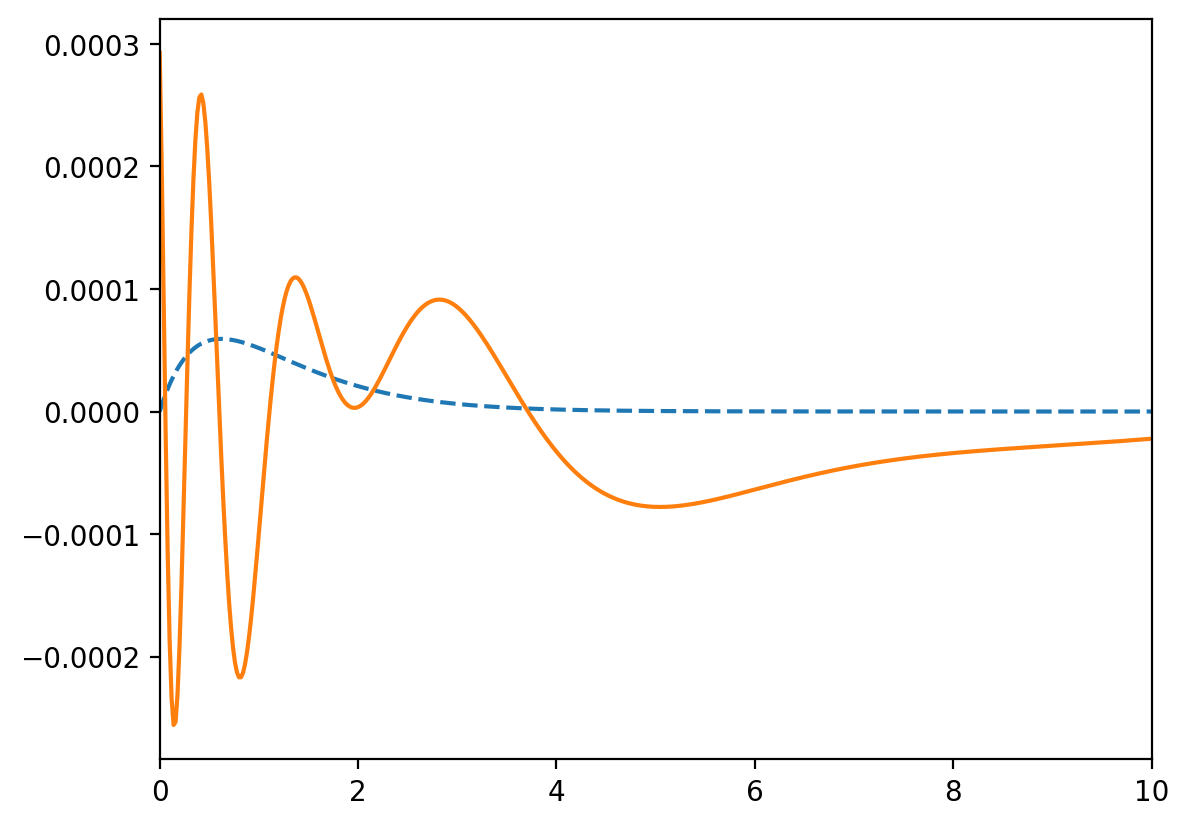

In [46]:
from scipy.optimize import least_squares
prony_2 = np.real(fft_ct - prony_ft)
# prony_2 = 1 * fft_t * np.e**(-1 * fft_t)


def fun_rosenbrock(x):
    return np.sum(np.abs(prony_2 - x[0] * fft_t * np.e**(-x[1] * fft_t) - x[2] * np.e**(-x[3] * fft_t)))


x0_rosenbrock = np.random.rand(4)
print(x0_rosenbrock)
res_1 = least_squares(fun_rosenbrock, x0_rosenbrock)
print(res_1.x)

plt.plot(fft_t, res_1.x[0] * fft_t * np.e**(-res_1.x[1] * fft_t), '--')
plt.plot(fft_t, prony_2)
plt.xlim(0, 10)


In [48]:
prony_2 = (fft_ct - prony_ft) / fft_t
prony_2[0] = prony_2[1]

h = prony_2
n_sample = n
H_r = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H_r[i, :] = np.real(h[i:n_sample + i])
vs_r, Qp_r = takagi_real(H_r, 20)
del H_r
gc.collect()
sort_array = np.argsort(vs_r)[::-1]
vs_r = vs_r[sort_array]
Qp_r = (Qp_r[:, sort_array])
np.save('Qp_r.npy', Qp_r)
np.save('vs_r.npy', vs_r)
print(vs_r[:40])

H_i = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H_i[i, :] = np.imag(h[i:n_sample + i])
vs_i, Qp_i = takagi_real(H_i, 20)
del H_i
gc.collect()
sort_array = np.argsort(vs_i)[::-1]
vs_i = vs_i[sort_array]
Qp_i = (Qp_i[:, sort_array])
np.save('Qp_i.npy', Qp_i)
np.save('vs_i.npy', vs_i)
print(vs_i[:40])


/tmp/ipykernel_43638/3765989812.py:1: RuntimeWarning: divide by zero encountered in true_divide


[1.94587086e-02 1.16230351e-02 6.26069055e-03 4.32139603e-03
 2.94277897e-03 2.58712717e-03 2.29438063e-03 2.04375627e-03
 1.87995365e-03 1.05741090e-03 9.83614005e-04 9.04944019e-04
 6.55201387e-04 2.73936926e-04 1.14406365e-04 4.63263118e-05
 1.17331479e-05 2.96446196e-06 9.94369818e-07 3.59045456e-07
 3.28345251e-07 1.78460606e-08 1.72475056e-08 1.51099878e-09
 5.91410421e-10 2.94235964e-10 2.19662582e-10 3.22625545e-11
 1.57235418e-11 1.51479298e-11 7.37512044e-12 2.18447619e-12
 1.09990706e-12 1.23123549e-13 8.63901162e-14 5.41489990e-14
 1.11320813e-14 1.89269701e-15 1.31182284e-15 1.13355454e-15]
[7.72541336e-02 4.75630611e-02 2.35238654e-02 1.19589971e-02
 3.12965949e-03 2.89835516e-03 2.55827243e-03 9.35001406e-04
 5.49821475e-04 5.21788386e-04 3.15487387e-04 2.42423701e-04
 1.54170775e-04 1.18634256e-04 1.01465150e-04 6.87510137e-05
 4.64649519e-05 1.33814070e-05 1.48897313e-06 6.94992262e-07
 3.44104392e-07 1.54497110e-07 3.53217971e-08 1.38643894e-09
 1.02168508e-09 1.32641

In [59]:
len_ = 100000
spe_wid = 20
w = np.append(np.linspace(-spe_wid, 0, len_),
              np.linspace(0, spe_wid, len_))
phixx = gen_jw(w)
scale = fft_t[-1]
for (n_gamma_r, n_gamma_i) in [(2, 2)]:
    # gamma_r = np.polynomial.polynomial.polyroots(Qp_r[:, n_gamma_r])
    gamma_r = np.load("gamma_new_r.npy")
    gamma_new_r = gamma_r[np.argsort(np.abs(gamma_r))[:n_gamma_r]]
    t_new_r = 2*n*np.log((gamma_new_r))

    # gamma_i = np.polynomial.polynomial.polyroots(Qp_i[:, n_gamma_i])
    gamma_i = np.load("gamma_new_i.npy")
    gamma_new_i = gamma_i[np.argsort(np.abs(gamma_i))[:n_gamma_i]]
    t_new_i = 2*n*np.log(gamma_new_i)

    # gamma_new = np.append(gamma_new_r, gamma_new_i)

    # n_gamma = n_gamma_r + n_gamma_i
    n_col = len(h)
    n_row = n_gamma_r
    gamma_m = np.zeros((2 * n_col, 2 * n_row), dtype=float)
    for i in range(n_row):
        for j in range(n_col):
            gamma_m[j, i] = np.real(gamma_new_r[i]**j)
            gamma_m[n_col + j, n_row + i] = np.real(gamma_new_r[i]**j)
            gamma_m[j, n_row + i] = -np.imag(gamma_new_r[i]**j)
            gamma_m[n_col + j, i] = np.imag(gamma_new_r[i]**j)
    h_m = np.append(np.real(h), np.zeros_like(h))
    omega_new_temp_r = (LA.inv(np.transpose(gamma_m) @ gamma_m)
                        @ np.transpose(gamma_m) @ np.transpose(h_m)).reshape(
        2, n_gamma_r)
    omega_new_r = omega_new_temp_r[0, :] + 1.j*omega_new_temp_r[1, :]

    n_col = len(h)
    n_row = n_gamma_i
    gamma_m = np.zeros((2 * n_col, 2 * n_row), dtype=float)
    for i in range(n_row):
        for j in range(n_col):
            gamma_m[j, i] = np.real(gamma_new_i[i]**j)
            gamma_m[n_col + j, n_row + i] = np.real(gamma_new_i[i]**j)
            gamma_m[j, n_row + i] = -np.imag(gamma_new_i[i]**j)
            gamma_m[n_col + j, i] = np.imag(gamma_new_i[i]**j)
    h_m = np.append(np.zeros_like(h), np.imag(h))
    omega_new_temp_i = (LA.inv(np.transpose(gamma_m) @ gamma_m)
                        @ np.transpose(gamma_m) @ np.transpose(h_m)).reshape(
        2, n_gamma_i)
    omega_new_i = omega_new_temp_i[0, :] + 1.j*omega_new_temp_i[1, :]

    etal2 = np.append(omega_new_r, omega_new_i).copy()

    t_new = np.append(t_new_r, t_new_i)
    expn2 = -t_new / scale


(0.0, 1000.0)

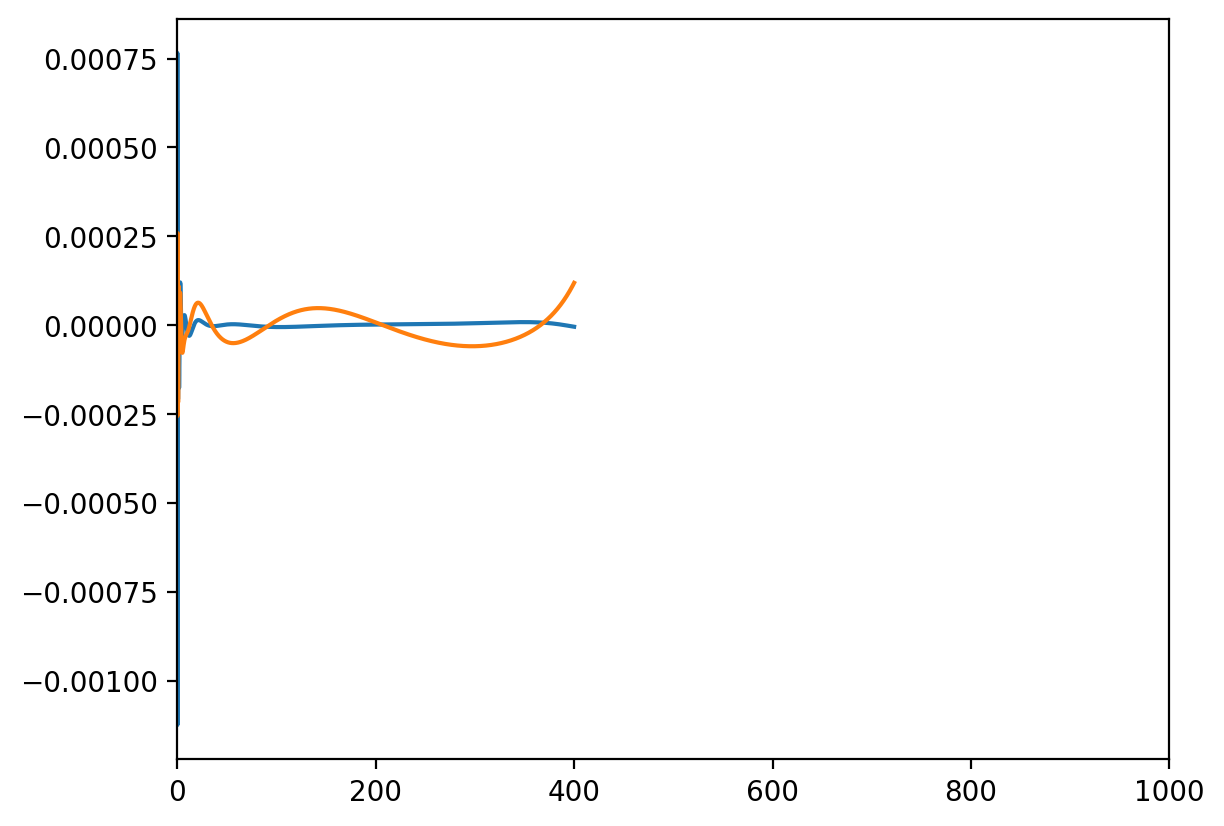

In [61]:
prony_ft2 = np.zeros_like(fft_t, dtype=complex)
# fit_t(fft_t, prony_ft2, expn, etal)
fit_t(fft_t, prony_ft2, expn2, etal2)
plt.plot(fft_t, fft_t * (np.imag(prony_2) - np.imag(prony_ft2)))
# plt.plot(fft_t, (np.imag(fft_ct)- np.imag(prony_ft)))
plt.plot(fft_t, fft_t * (np.real(prony_2) - np.real(prony_ft2)))
# plt.plot(fft_t, (np.real(fft_ct) - np.real(prony_ft)))
# plt.ylim(-1e-5, 1e-5)
plt.xlim(0, 1000)


In [58]:
expn2


array([21.3903877 -33.5527609j , 21.3903877 +33.5527609j ,
        1.98199832 +9.21681903j,  1.98199832 -9.21681903j,
       59.9432523 -53.58642586j, 59.9432523 +53.58642586j,
        6.12483959-10.50164864j,  6.12483959+10.50164864j])